In [1]:
using PyCall
# push local path to python path
pushfirst!(PyVector(pyimport("sys")["path"]), "")
#lkTable=pyimport("lkTables")
py_util=pyimport("python_util")

PyObject <module 'python_util' from '/Users/mgrecu/NewFrameworks/eddgn_jacobian/python_util.py'>

In [2]:
#println(py_util.lookupT.dmr)
fname="/Users/mgrecu/GPM/ORO_old/2A-CS/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20190502-S100527-E101407.029398.V07A.HDF5"
qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat=py_util.readCMB(fname);
 

In [12]:
nt=size(zCorrected)[1]
#kext_gases=np.zeros((nt,49,78,8))
#temp_layer=np.zeros((nt,49,79))
np=pyimport("numpy")
freqs=[10.65,18.7,23.8,37.0,89.0,166,183.3+3,183.3+7]
hFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,7]
gFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,8]
kext_atm=np.zeros((nt,49,79,8))
for i in 1:nt
    for j in 1:49
        n5=envNodes[i,j,:]
        press1d=np.interp(10:88,n5,press[i,j,:])
        qv1d=np.interp(10:88,n5,qv[i,j,:])
        temp1d=np.interp(10:88,n5,airTemp[i,j,:])
        temp_layer1d=np.interp(np.arange(9.5,88.5,1),n5,airTemp[i,j,:])
        qv1d[qv1d.<1e-3].=1e-3
        rho1d=press1d./(287.05*temp1d)*1e2
        ireturn=0
        rhowv1d=rho1d.*qv1d.*1e-3
        press1d_pa=press1d.*1e2
        kext = py_util.rt.get_wv_extinction(freqs,temp1d,rhowv1d,press1d_pa)
        kext_atm[i,j,:,:]=kext';
    end
end
      

In [18]:

ind=find_closest(x,xv);
print(ind)

4

In [38]:

# Assuming nt, a, pwc, binNodes, dm, pType, lookupT, sfcBin are defined and initialized

kext3d = zeros(Float64, nt, 49, 88, 7)
salb3d = zeros(Float64, nt, 49, 88, 7)
asym3d = zeros(Float64, nt, 49, 88, 7)
iwp = zeros(Float64, nt, 49)
rwp = zeros(Float64, nt, 49)

function bisectm(xvec, r)
    n = length(xvec)
    if r <= xvec[1]
        return 1
    elseif r >= xvec[n]
        return n
    end
    
    low, high = 1, n
    while low <= high
        mid = div(low + high, 2)
        if xvec[mid] == r
            return mid
        elseif xvec[mid] < r
            low = mid + 1
        else
            high = mid - 1
        end
    end
    
    if abs(xvec[low] - r) < abs(xvec[high] - r)
        return low
    else
        return high
    end
end
println(nt)


743


In [35]:
println(maximum(pwc))
icount=0
for i in 1:nt
    for j in 1:49
        pwc1 = pwc[i, j, :]
        a0 = findall(pwc1.>0)
        if length(a0) == 0
            continue
        end
        icount+=1
    end
end
println()
println(icount, " ", nt*49)
println(maximum(iwp), " ", maximum(rwp))


16.846258

3554 36407
0.0 0.0


In [43]:
lookupT=py_util.lookupT
kext_rain=zeros(Float64,7)
salb_rain=zeros(Float64,7)
asym_rain=zeros(Float64,7)
for i in 1:nt
    for j in 1:49
        pwc1 = pwc[i, j, :]
        a0 = findall(pwc1.>0)
        for k in a0
            dm1 = dm[i, j, k]
            if k <= binNodes[i, j, 4]
                iphase = 0
                if pType[i, j] != 2
                    ind = bisectm(lookupT.dms, dm1)
                    dns = log10(pwc[i, j, k] / lookupT.swc[ind])
                    kext_snow = lookupT.kextS[ind, :] .* 10^dns
                    salb_snow = lookupT.salbS[ind, :]
                    asym_snow = lookupT.asymS[ind, :]
                else
                    ind = bisectm(lookupT.dmg.data, dm1)
                    dng = log10(pwc[i, j, k] / lookupT.gwc[ind])
                    kext_snow = lookupT.kextG[ind, :] .* 10^dng
                    salb_snow = lookupT.salbG[ind, :]
                    asym_snow = lookupT.asymG[ind, :]
                end
            end

            if k > binNodes[i, j, 2]
                ind = bisectm(lookupT.dmr, dm1)
                dnr = log10(pwc[i, j, k] / lookupT.rwc[ind])
                kext_rain = lookupT.kextR[ind, :] .* 10^dnr
                salb_rain = lookupT.salbR[ind, :]
                asym_rain = lookupT.asymR[ind, :]
            end
        
            if k <= binNodes[i, j, 2]
                kext = kext_snow
                salb = salb_snow
                asym = asym_snow
            else
                if k < binNodes[i, j, 4]
                    f = (k - binNodes[i, j, 2]) / (binNodes[i, j, 4] - binNodes[i, j, 2])
                    kext = kext_snow .* (1 - f) + kext_rain .* f
                    salb = (salb_snow .* (1 - f) .* kext_snow + salb_rain .* f .* kext_rain)
                    asym = (asym_snow .* (1 - f) .* kext_snow .* asym_snow + asym_rain .* f .* kext_rain .* asym_rain) ./ salb
                    salb = salb ./ kext
                else
                    kext = kext_rain
                    salb = salb_rain
                    asym = asym_rain
                end
            end
        
            kext3d[i, j, k, :] = kext
            salb3d[i, j, k, :] = salb
            asym3d[i, j, k, :] = asym
        
            if k == a0[end]
                for k1 in k+1:88
                    kext3d[i, j, k1, :] = kext_rain
                    salb3d[i, j, k1, :] = salb_rain
                    asym3d[i, j, k1, :] = asym_rain
                end
            #    kext3d[i, j, k+1:end, :] .= kext_rain
            #    salb3d[i, j, k+1:end, :] .= salb_rain
            #    asym3d[i, j, k+1:end, :] .= asym_rain
            #    if pwc1[k] == pwc1[k] && sfcBin[i, j, 1] == sfcBin[i, j, 1]
            #        if k >= binNodes[i, j, 3]
            #            rwp[i, j] += pwc1[k] * 0.25 * (sfcBin[i, j, 1] - k)
            #        else
            #            iwp[i, j] += pwc1[k] * 0.25 * (sfcBin[i, j, 1] - k)
            #        end
            #    end
            end
        end
    end
end


In [24]:

find_closest(py_util.lookupT.dmr,1.5)
print(py_util.lookupT.dmr[198])

1.503021

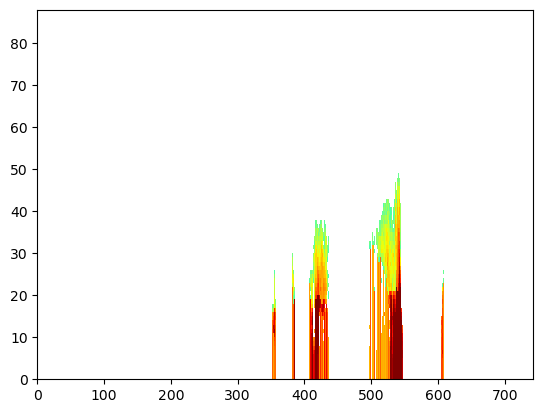

PyObject <matplotlib.collections.QuadMesh object at 0x1650e99c0>

In [65]:
using PyPlot
mplt=pyimport("matplotlib.pyplot")
mcolors=pyimport("matplotlib.colors")
#plt=pyimport("matplotlib.pyplot")
plt.pcolormesh(kext3d[:,25,end:-1:1,4]',norm=mcolors.LogNorm(vmin=1e-5,vmax=1e-1),cmap="jet")
#xlim(500,600)
#ylim(0,45)

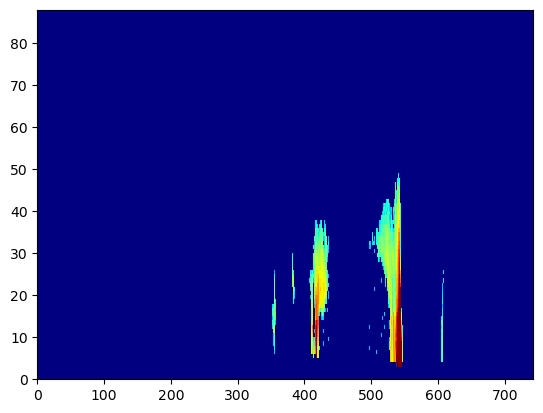

PyObject <matplotlib.collections.QuadMesh object at 0x30372fb20>

In [7]:
#using PyPlot
#pcolormesh(zCorrected[:,25,end:-1:1,1]',cmap="jet",vmin=0,vmax=40)